## Predicting Football Results using Poisson Distribution

This project will try to predict football match results of 2023/24 season using poisson distribution model.
The features used for prediction is entirely based on expected goals stats of previous games rather than the actual goals scored.

Football especially goals scored can be so random that prediction solely based on goals scored can be misleading. The amount of goals a team scored does not necessarily show how the team has performed in the game and if we use that to predict future results, it can lead to wrong prediction. That is when the use of expected goals (XG) can be helful. 

According to **statsbomb**, which is the leading data provider and a household name in football and other sports, **Expected Goals (xG) is a metric designed to measure the probability of a shot resulting in a goal.
An xG model uses historical information from thousands of shots with similar characteristics to estimate the likelihood of a goal on a scale between 0 and 1.Each xG model has its own characteristics, but these are the main factors that have traditionally been fed into the large majority of Expected Goals models: distance to goal, angle to goal, body part with which the shot was taken, and type of assist or previous action (throughball, cross, set-piece, dribble, etc…). Based on historical information of shots with similar characteristics, the xG model then attributes a value between 0 and 1 to each shot that expresses the probability of it producing a goal.**



In [3]:
import pandas as pd
import numpy as np

In [182]:
url='https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'

In [183]:
ligue_list = []

ligue_list.append(pd.read_html(url,index_col=False,flavor='lxml')[0])
ligue_list = pd.concat(ligue_list, axis=0, ignore_index=True)

In [184]:
pl_df = ligue_list[ligue_list['Wk'].notna()] # drop na

In [185]:
pl_df.head()

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN
1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN
2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN
3,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN
4,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN


In [186]:
pl_df = pl_df.rename(columns={'xG':'xGHome'
                   ,'xG.1':'xGAway'})

In [187]:
pl_df['HomeScore'] = pl_df['Score'].str[0]
pl_df['AwayScore'] = pl_df['Score'].str[2]

In [188]:
pl_df = pl_df.drop(['Match Report','Notes'],axis=1)

In [189]:
pl_df.head()

,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,Attendance,Venue,Referee,HomeScore,AwayScore
0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,0,3
1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,2,1
2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,0,1
3,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,0,1
4,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,4,1


In [190]:
#convert to date

pl_df['Date'] = pd.to_datetime(pl_df['Date'])

pl_df.sort_values(by='Date', inplace=True)

pl_df = pl_df[['Wk','Day','Date','Time','Home','HomeScore','xGHome','AwayScore','xGAway','Away','Attendance','Venue','Referee']]

In [ ]:
pl_df["hour"] = pl_df["Time"].str.replace(":.+", "", regex=True).astype("int")

In [191]:
pl_df.columns

Index(['Wk', 'Day', 'Date', 'Time', 'Home', 'HomeScore', 'xGHome', 'AwayScore',
       'xGAway', 'Away', 'Attendance', 'Venue', 'Referee'],
      dtype='object')

In [234]:
#removes the fixtures that are not played yet
pl_df = pl_df.dropna()

#### Match time and quality

Does match time affects the quality of premier league games in terms of xG. We will investigate whether scheduling have an impact on the number of xg chances teams create and concede.

In order to do that let's create new column 'xGGame' by adding the home and away xg to find the total xG for a game.

**However we have to note that quality of the games can not be solely measured by the number of high quality chances or goals. A game can be end to end, entertainninig while ending in a goalless draw.**

In [227]:
pl_df['xGGame']=pl_df['xGHome'] + pl_df['xGAway']

In [225]:
pl_df.groupby(['Day','Time'])[['xGGame']].agg([np.mean,np.median])

xGGame       
               mean median
Day Time                  
Fri 19:45  1.900000    1.9
    20:00  2.225000    2.3
Mon 19:45  1.200000    1.2
    20:00  3.540000    3.0
Sat 12:30  2.763636    2.8
    15:00  3.062264    2.9
    17:30  2.961538    2.9
    20:00  2.300000    2.3
Sun 13:00  1.500000    1.5
    14:00  3.169565    3.2
    15:30  4.900000    4.9
    16:30  3.230000    3.1
Tue 19:30  2.400000    2.4

In [250]:
pl_df['xGGame'].describe()

count    126.000000
mean       3.011905
std        1.000448
min        0.900000
25%        2.300000
50%        2.900000
75%        3.600000
max        5.800000
Name: xGGame, dtype: float64

In [249]:
pl_df[pl_df['Time']=='19:45']

,Wk,Day,Date,Time,Home,HomeScore,xGHome,AwayScore,xGAway,Away,Attendance,Venue,Referee,hour,xGGame
11,2.0,Fri,2023-08-18,19:45,Nott'ham Forest,2,1.4,1,0.5,Sheffield Utd,29432.0,The City Ground,Peter Bankes,19,1.9
52,5.0,Mon,2023-09-18,19:45,Nott'ham Forest,1,0.7,1,0.5,Burnley,28958.0,The City Ground,Robert Jones,19,1.2


On Average Early kick off time on Sunday(13:00 UK time) had lowest xG  games (1.5 average xG), while Saturday early kick off time had on average around 2.76 xG. However the other Super Sunday games involve ganes with high xg chances. 
There is no enough sample size to conclude that a 19:45 Monday night game is too dull as the only match played on the day and time was **'Nott'ham Forest' vs 'Burnley'**

The super Sunday 16:30 games which usually involves games with the traditional top six teams lived upto the expectation with an average xG of 3.1. 

This is an interesting observations as teams who usually play on early Sunday are those teams that are involved in  Europa League on Thursday Night and could be very tired, more tired than a Champions League side would be on a Saturday.

#### Poisson Model

Poisson regression is a statistical model that can be used to model count data, which makes it very well suited to predict the number of goals scored a team scores in a football match.

In [224]:
pl_df.groupby(['Date'])[['xGAway']].agg([np.mean,np.median]).head()

xGAway       
             mean median
Date                    
2023-08-11    1.9    1.9
2023-08-12    1.5    1.5
2023-08-13    1.3    1.3
2023-08-14    2.2    2.2
2023-08-18    0.5    0.5

Remove those fixtures that are not played yet

In [153]:
pl_df = pl_df.dropna()
pl_df = pl_df[['Date','Home','HomeScore','xGHome','AwayScore','xGAway','Away']].reset_index(drop=True)

In [154]:
pl_df.head()

,Date,Home,HomeScore,xGHome,AwayScore,xGAway,Away
0,2023-08-11,Burnley,0,0.3,3,1.9,Manchester City
1,2023-08-12,Arsenal,2,0.8,1,1.2,Nott'ham Forest
2,2023-08-12,Everton,0,2.7,1,1.5,Fulham
3,2023-08-12,Sheffield Utd,0,0.5,1,1.9,Crystal Palace
4,2023-08-12,Brighton,4,4.0,1,1.5,Luton Town


To model relative home/away xGs ratings for home offense/away offense/ home defense and away defense, we need to calculate the league mean home and away xG figures

In [228]:
league_Mean_Home_xG = round((pl_df['xGHome'].mean()),2)
league_Mean_Away_xG = round((pl_df['xGAway'].mean()),2)

In [229]:
print(f"The mean league home expected goal is:", league_Mean_Home_xG)
print(f"The mean league away expected goal is:", league_Mean_Away_xG)

The mean league home expected goal is: 1.6
The mean league away expected goal is: 1.41


Next step is to calculate the respective xG offense rating for home and away teams and compare it the league. 

In [230]:
home_team_xg_strength_offense = pl_df.groupby('Home').agg({'xGHome': 'sum', 'Home': ['count', 'first']})

In [231]:
home_team_xg_strength_offense

xGHome  Home                 
                   sum count            first
Home                                         
Arsenal           13.1     7          Arsenal
Aston Villa       14.7     6      Aston Villa
Bournemouth        7.7     7      Bournemouth
Brentford         12.8     7        Brentford
Brighton          13.9     7         Brighton
Burnley            6.5     7          Burnley
Chelsea           13.3     7          Chelsea
Crystal Palace     7.0     6   Crystal Palace
Everton           10.3     6          Everton
Fulham             5.8     5           Fulham
Liverpool         15.6     6        Liverpool
Luton Town         7.3     6       Luton Town
Manchester City    7.5     5  Manchester City
Manchester Utd    11.8     7   Manchester Utd
Newcastle Utd     15.6     7    Newcastle Utd
Nott'ham Forest    8.0     6  Nott'ham Forest
Sheffield Utd      6.5     7    Sheffield Utd
Tottenham          8.4     5        Tottenham
West Ham           8.5     6         West Ham
Wolves             7.8     6           Wolves

In [159]:
home_team_xg_strength_offense.columns=['xGHome', 'TotalGames', 'Home']

In [160]:
home_team_xg_strength_offense['xGHome_offense_rating'] = (home_team_xg_strength_offense['xGHome'] / home_team_xg_strength_offense['TotalGames']) /league_Mean_Home_xG
home_team_xg_strength_offense = home_team_xg_strength_offense.reset_index(drop = True)
home_team_xg_strength_offense = pd.DataFrame(home_team_xg_strength_offense)
home_team_xg_strength_offense.columns = ['xGHome', 'TotalGames','Home','xGHome_offense_rating']
home_team_xg_strength_offense = home_team_xg_strength_offense[['Home','xGHome','TotalGames','xGHome_offense_rating']]
home_team_xg_strength_offense.sort_values('xGHome_offense_rating', ascending=False)

,Home,xGHome,TotalGames,xGHome_offense_rating
10,Liverpool,15.6,6,1.625000
1,Aston Villa,14.7,6,1.531250
14,Newcastle Utd,15.6,7,1.392857
4,Brighton,13.9,7,1.241071
6,Chelsea,13.3,7,1.187500
0,Arsenal,13.1,7,1.169643
3,Brentford,12.8,7,1.142857
8,Everton,10.3,6,1.072917
13,Manchester Utd,11.8,7,1.053571
17,Tottenham,8.4,5,1.050000


Let's do the same for the awy team offense strength

In [161]:
away_team_xg_strength_offense = pl_df.groupby('Away').agg({'xGAway': 'sum', 'Away': ['count', 'first']})

In [162]:
away_team_xg_strength_offense

xGAway  Away                 
                   sum count            first
Away                                         
Arsenal            9.5     6          Arsenal
Aston Villa        8.8     6      Aston Villa
Bournemouth        8.8     6      Bournemouth
Brentford         10.5     6        Brentford
Brighton           8.4     6         Brighton
Burnley            4.4     6          Burnley
Chelsea           12.6     6          Chelsea
Crystal Palace     8.6     7   Crystal Palace
Everton            7.4     6          Everton
Fulham             6.7     7           Fulham
Liverpool         11.5     7        Liverpool
Luton Town         6.5     7       Luton Town
Manchester City   17.3     7  Manchester City
Manchester Utd     5.8     5   Manchester Utd
Newcastle Utd      9.8     5    Newcastle Utd
Nott'ham Forest    7.3     7  Nott'ham Forest
Sheffield Utd      4.0     6    Sheffield Utd
Tottenham         10.7     7        Tottenham
West Ham          10.1     7         West Ham
Wolves             8.7     6           Wolves

In [163]:
away_team_xg_strength_offense.columns=['xGAway', 'TotalGames', 'Away']

In [232]:
away_team_xg_strength_offense['xGAway_offense_rating'] = (away_team_xg_strength_offense['xGAway'] / away_team_xg_strength_offense['TotalGames']) /league_Mean_Away_xG
away_team_xg_strength_offense = away_team_xg_strength_offense.reset_index(drop = True)
away_team_xg_strength_offense = pd.DataFrame(away_team_xg_strength_offense)
away_team_xg_strength_offense.columns = ['xGAway', 'TotalGames','Away','xGAway_offense_rating']
away_team_xg_strength_offense = away_team_xg_strength_offense[['Away','xGAway','TotalGames','xGAway_offense_rating']]
away_team_xg_strength_offense.sort_values('xGAway_offense_rating', ascending=False)

,Away,xGAway,TotalGames,xGAway_offense_rating
12,7,Manchester City,17.3,1.752786
6,6,Chelsea,12.6,1.489362
14,5,Newcastle Utd,9.8,1.390071
3,6,Brentford,10.5,1.241135
10,7,Liverpool,11.5,1.165147
0,6,Arsenal,9.5,1.122931
17,7,Tottenham,10.7,1.084093
1,6,Aston Villa,8.8,1.040189
2,6,Bournemouth,8.8,1.040189
19,6,Wolves,8.7,1.028369


In [165]:
away_team_xg_strength_offense = pl_df.groupby('Away').agg({'xGAway': 'sum', 'Away': ['count', 'first']})
away_team_xg_strength_offense.columns = ['xGAway', 'TotalGames', 'Away']
away_team_xg_strength_offense['xGAway_offense_rating'] = (away_team_xg_strength_offense['xGAway'] / away_team_xg_strength_offense['TotalGames']) / league_Mean_Away_xG
away_team_xg_strength_offense = away_team_xg_strength_offense.reset_index(drop = True)
away_team_xg_strength_offense = pd.DataFrame(away_team_xg_strength_offense)
away_team_xg_strength_offense.columns = ['xGAway', 'TotalGames','Away','xGAway_offense_rating']
away_team_xg_strength_offense = away_team_xg_strength_offense[['Away','xGAway','TotalGames','xGAway_offense_rating']]
away_team_xg_strength_offense.sort_values('xGAway_offense_rating', ascending=False)                         

,Away,xGAway,TotalGames,xGAway_offense_rating
12,Manchester City,17.3,7,1.752786
6,Chelsea,12.6,6,1.489362
14,Newcastle Utd,9.8,5,1.390071
3,Brentford,10.5,6,1.241135
10,Liverpool,11.5,7,1.165147
0,Arsenal,9.5,6,1.122931
17,Tottenham,10.7,7,1.084093
1,Aston Villa,8.8,6,1.040189
2,Bournemouth,8.8,6,1.040189
19,Wolves,8.7,6,1.028369


In [166]:
home_team_xg_strength_defence = pl_df.groupby('Home').agg({'xGAway': 'sum', 'Home': ['count', 'first']})

home_team_xg_strength_defence.columns = ['xG_Conceded', 'TotalGames', 'Home']

home_team_xg_strength_defence['xG_home_defense_rating'] = (home_team_xg_strength_defence['xG_Conceded'] / home_team_xg_strength_defence['TotalGames']) / league_Mean_Away_xG

home_team_xg_strength_defence = home_team_xg_strength_defence.reset_index(drop = True)
home_team_xg_strength_defence = pd.DataFrame(home_team_xg_strength_defence)

home_team_xg_strength_defence.columns = ['xG_Conceded', 'TotalGames','Home','xG_home_defense_rating']

home_team_xg_strength_defence = home_team_xg_strength_defence[['Home','xG_Conceded','TotalGames','xG_home_defense_rating']]
home_team_xg_strength_defence.sort_values('xG_home_defense_rating', ascending=True)  

,Home,xG_Conceded,TotalGames,xG_home_defense_rating
0,Arsenal,4.9,7,0.496454
10,Liverpool,5.2,6,0.614657
14,Newcastle Utd,6.2,7,0.628166
12,Manchester City,4.7,5,0.666667
8,Everton,5.7,6,0.673759
1,Aston Villa,6.0,6,0.709220
15,Nott'ham Forest,7.0,6,0.827423
7,Crystal Palace,7.4,6,0.874704
6,Chelsea,9.6,7,0.972644
11,Luton Town,8.5,6,1.004728


In [43]:
away_team_xg_strength_defence = pl_df.groupby('Away').agg({'xGHome': 'sum', 'Away': ['count', 'first']})

away_team_xg_strength_defence.columns = ['xG_Conceded', 'TotalGames', 'Away']

away_team_xg_strength_defence['xG_away_defense_rating'] = (away_team_xg_strength_defence['xG_Conceded'] / away_team_xg_strength_defence['TotalGames']) / league_Mean_Home_xG

away_team_xg_strength_defence = away_team_xg_strength_defence.reset_index(drop = True)
away_team_xg_strength_defence = pd.DataFrame(away_team_xg_strength_defence)

away_team_xg_strength_defence.columns = ['xG_Conceded', 'TotalGames','Away','xG_away_defense_rating']

away_team_xg_strength_defence = away_team_xg_strength_defence[['Away','xG_Conceded','TotalGames','xG_away_defense_rating']]
away_team_xg_strength_defence.sort_values('xG_away_defense_rating', ascending=True)  

,Away,xG_Conceded,TotalGames,xG_away_defense_rating
0,Arsenal,4.2,5,0.518519
12,Manchester City,6.5,7,0.573192
6,Chelsea,5.5,5,0.679012
3,Brentford,7.4,6,0.761317
4,Brighton,6.2,5,0.765432
14,Newcastle Utd,6.7,5,0.827160
17,Tottenham,9.5,7,0.837743
13,Manchester Utd,7.5,5,0.925926
10,Liverpool,9.3,6,0.956790
19,Wolves,9.3,6,0.956790


Let's try to predivt Tottenham Vs Aston Villa gane to be played on 26/11

In [167]:
Tottenham_home_offense_rating = 1.037037
Aston_Villa_away_defense_rating = 1.018519

Tottenham_home_expected_xg = (Tottenham_home_offense_rating * Aston_Villa_away_defense_rating) * league_Mean_Home_xG
Tottenham_home_expected_xg

1.6899870211248

In [168]:
Aston_Villa_away_offense_rating = 1.040189
Tottenham_home_defense_rating = 1.304965

Aston_Villa_away_expected_xg = (Aston_Villa_away_offense_rating * Tottenham_home_defense_rating) * league_Mean_Away_xG

Aston_Villa_away_expected_xg

1.9139484361228498

We expect Tottenham to score an XG of 1.69 while Villa are expected to have 1.91 XG

#### Poisson Distribution Model

The Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space. The poisson distribution considers the events occur at a constant mean rate and assume the events occur independently.

To model the probabilities of Tottenham and Aston Villa scoring goals, let's use a poisson distribution model.

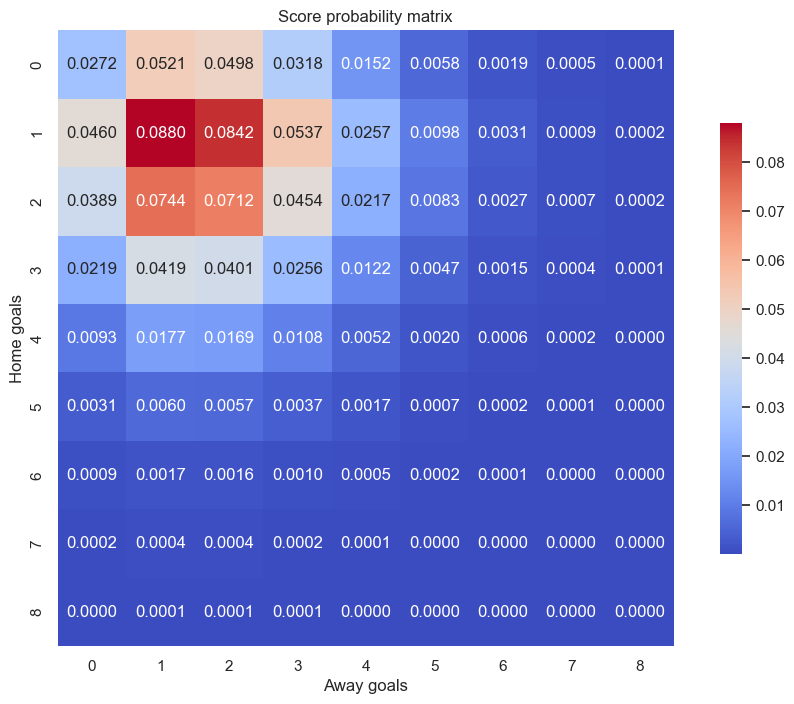

In [169]:
import numpy as np
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt

home_expectancy = Tottenham_home_expected_xg
away_expectancy = Aston_Villa_away_expected_xg


max_score = 8
score_range = np.arange(0, max_score+1)

home_pmf = poisson.pmf(score_range, home_expectancy)
away_pmf = poisson.pmf(score_range, away_expectancy)

# calculate the outer product of the home and away PMFs
score_prob_matrix = np.outer(home_pmf, away_pmf)

# reshape the matrix into a square matrix of score probabilities
score_prob_matrix = score_prob_matrix.reshape(max_score+1, max_score+1)


# set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# create a heatmap using seaborn
sns.set()
sns.heatmap(score_prob_matrix, cmap="coolwarm", annot=True, fmt=".4f", square=True, cbar_kws={"shrink": 0.7}, ax=ax)

# set the axis labels and title
plt.xlabel("Away goals")
plt.ylabel("Home goals")
plt.title("Score probability matrix")

# display the plot
plt.show()

In [233]:
display(
        poisson.pmf(1,Tottenham_home_expected_xg),
        poisson.pmf(2,Aston_Villa_away_expected_xg)
       )

0.3118396479938869

0.27015513468060354

The probabilty of Tottenham scoring one goal in the game is  31.2% while Aston Villa scoring one goal in this game has a 27% chance .

In [173]:
np.exp(-1.6899870211248)*1.6899870211248

0.31183964799388697

In [172]:
np.exp(-1.9139484361228498
)*1.9139484361228498


0.2823013719511336

In [174]:
# calculate the sums of home wins, draws, and away wins
home_wins = np.sum(np.tril(score_prob_matrix, -1))
draws = np.sum(np.diag(score_prob_matrix))
away_wins = np.sum(np.triu(score_prob_matrix, 1))

# create a table to display the sums
table_data = {
    "Home wins": [home_wins],
    "Draws": [draws],
    "Away wins": [away_wins]
}
table = pd.DataFrame(table_data)

# display the table
print(table)

   Home wins     Draws  Away wins
0   0.345723  0.217925    0.43611


In [175]:
#The odds of the result can then be caLCULATED
print(f"The odds of Tottenham winning the game:", str(1/home_wins))

The odds of Tottenham winning the game: 2.892485772706969


In [176]:
print(f"The odds of Aston Villa winning the game:", str(1/away_wins))

The odds of Aston Villa winning the game: 2.2929975718854045


In [177]:
print(f"The odds of draw:",str(1/draws) )

The odds of draw: 4.588729249218039


The likely possible outcomes from the  posson matrix model is the game finishing either 1-1 followed by 2-2, 1-2

##### Limitations 

Poisson model is a statistical model that offers estimated probabilities, not certainties. It needs to be fed more data to get a close to accurate prediction On the other hand, no team in football performs the same in everygame throughout the season. There are up and downs. For instance, a team performance can be greatly affected by an injury to its key player.
Match prediction becomes better as the season goes longer since there will be more team data available.

The poisson model I used here is a very simple one with limited features. The bookies use number of years of data, match sentiment, predicted lineups, and other complex machine learning algorithms to calculate chance of teams winning,losing or draw.